In [2]:
%matplotlib inline
import glob
import re
import sys
import math
import matplotlib
import seaborn
import numpy
from matplotlib import pyplot as plt
from collections import defaultdict

from evalutils import IntervalForest, populate_index_from_bed, compact
from evalutils import subset_variants_bed, load_kevlar_vcf, load_gatk_mvf, load_triodenovo_vcf
import kevlar

seaborn.set_context({'figure.figsize': (24, 12)})
matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [3]:
def roc(calls, index, delta=10, fmt='vcf'):
    ncorrect = 0
    num_true_calls_per_false_call = list()
    for varcall in calls:
        if fmt == 'vcf':
            valid = index.query(varcall.seqid, varcall.position, delta=delta) != set()
        elif fmt == 'mvf':
            callindex, call = varcall
            valid = index.query(call['CHROM'], call['POS'], delta=delta) != set()
        else:
            raise ValueError('unknown format "'+ fmt +'"')
        if valid:
            ncorrect += 1
            continue
        num_true_calls_per_false_call.append(ncorrect)
    if len(num_true_calls_per_false_call) == 0 or ncorrect > num_true_calls_per_false_call[-1]:
        num_true_calls_per_false_call.append(ncorrect)
    return num_true_calls_per_false_call

In [4]:
def doplot(axis, data, color, label, linestyle, symbol):
    if len(data) == 1:
        axis.plot(range(len(data)), data, symbol, color=color, label=label)
    else:
        axis.plot(range(len(data)), data, color=color, linestyle=linestyle, label=label)

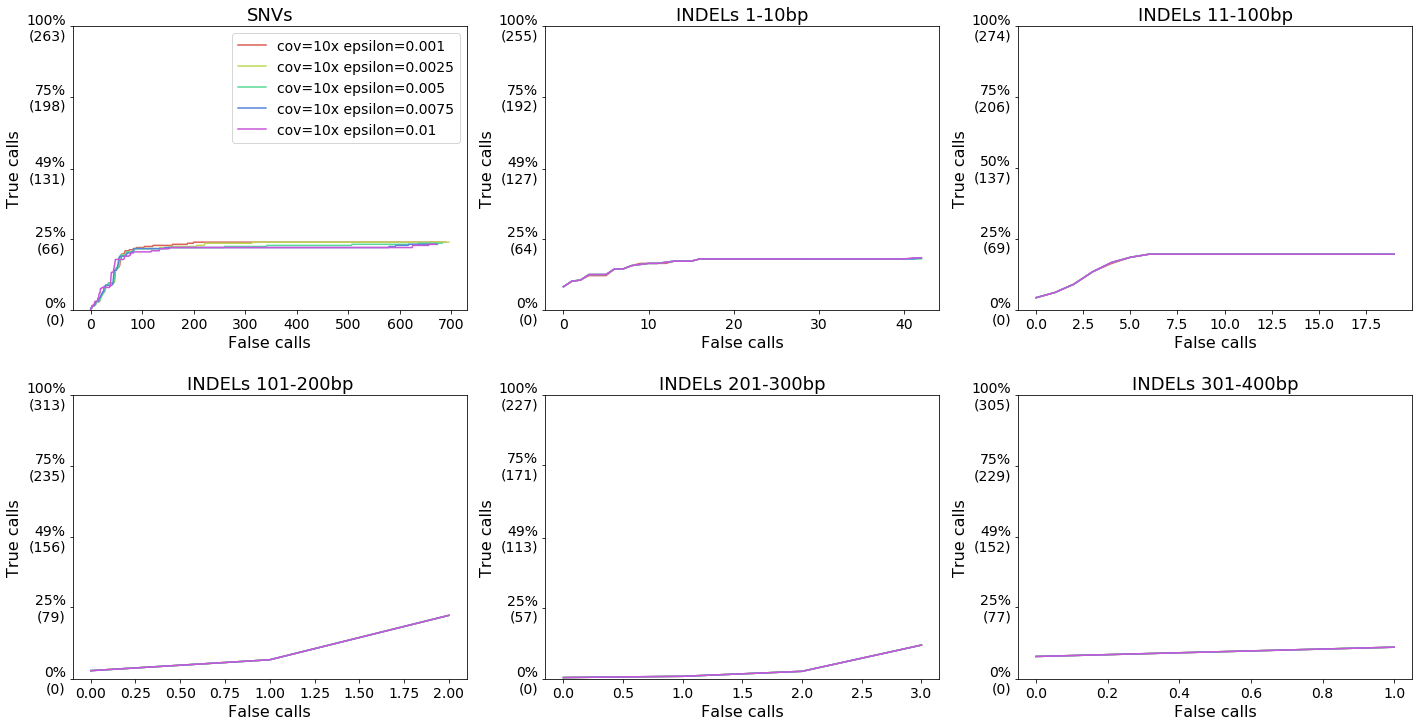

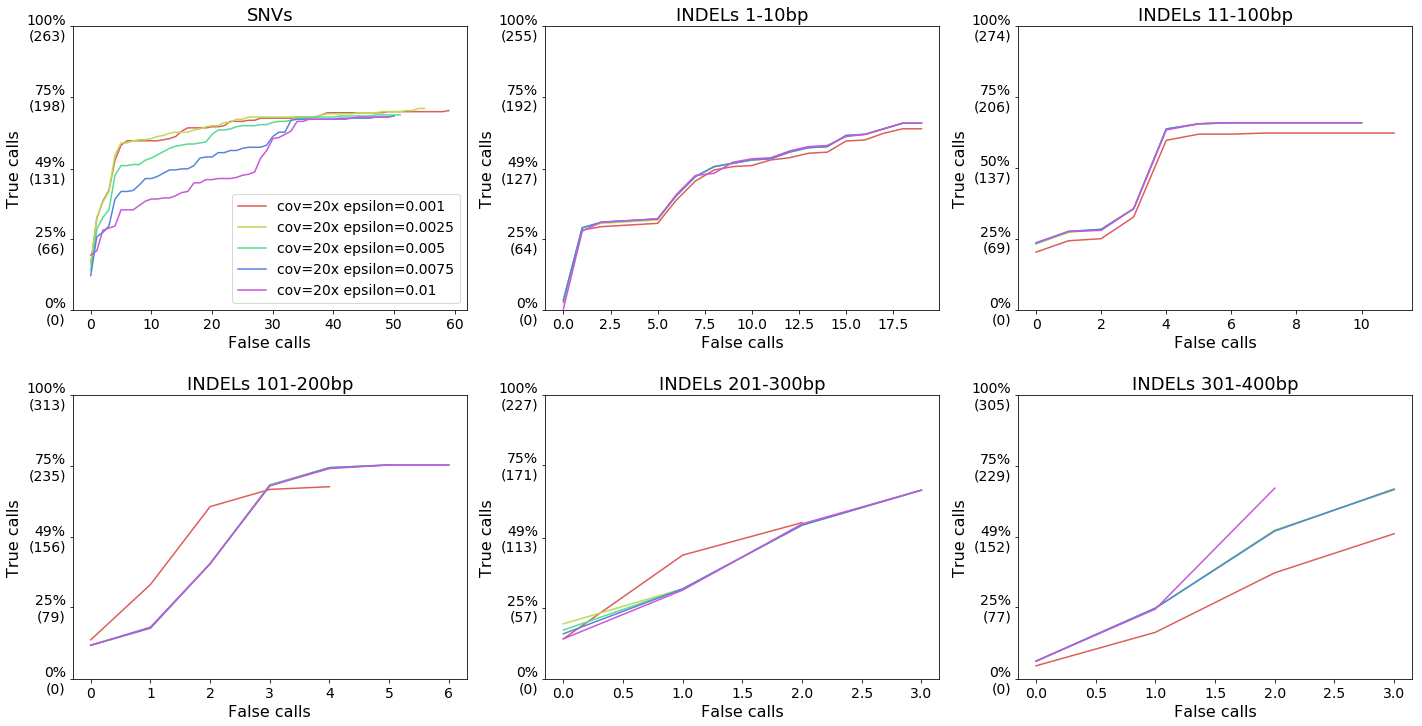

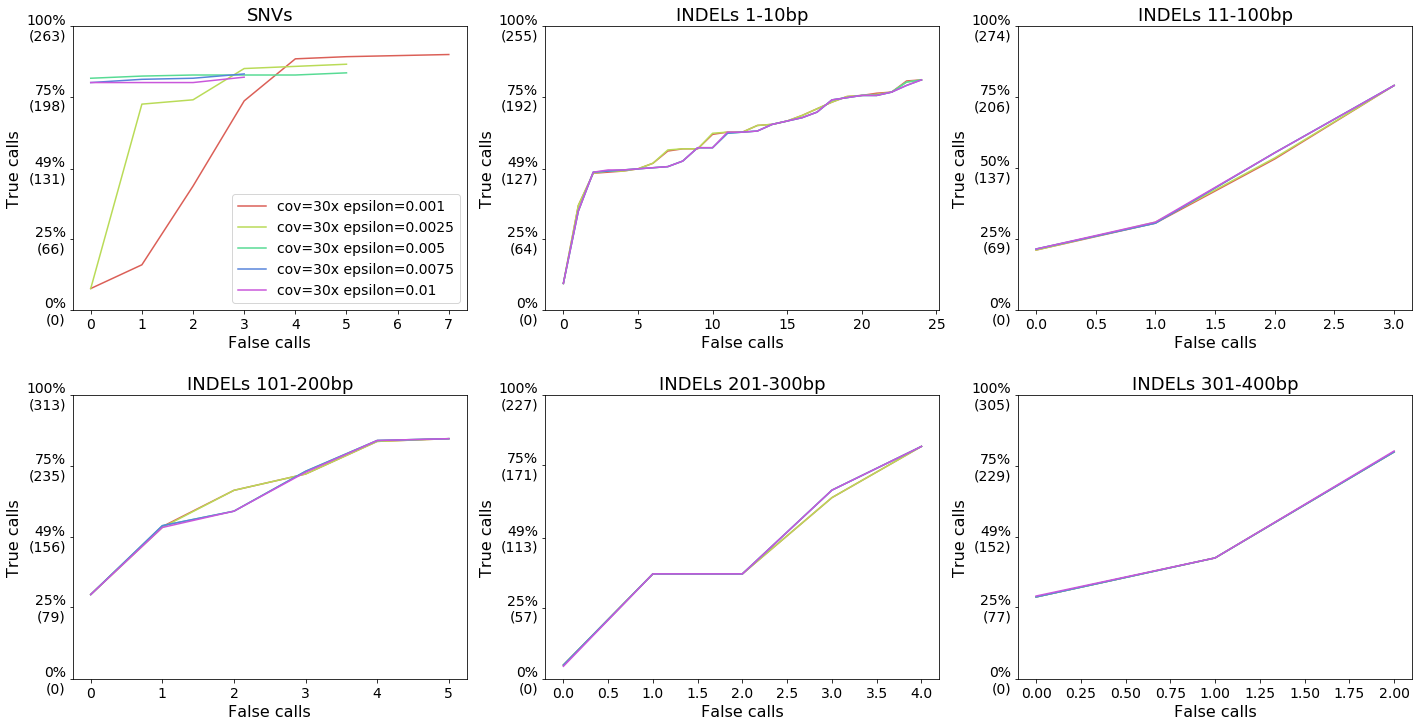

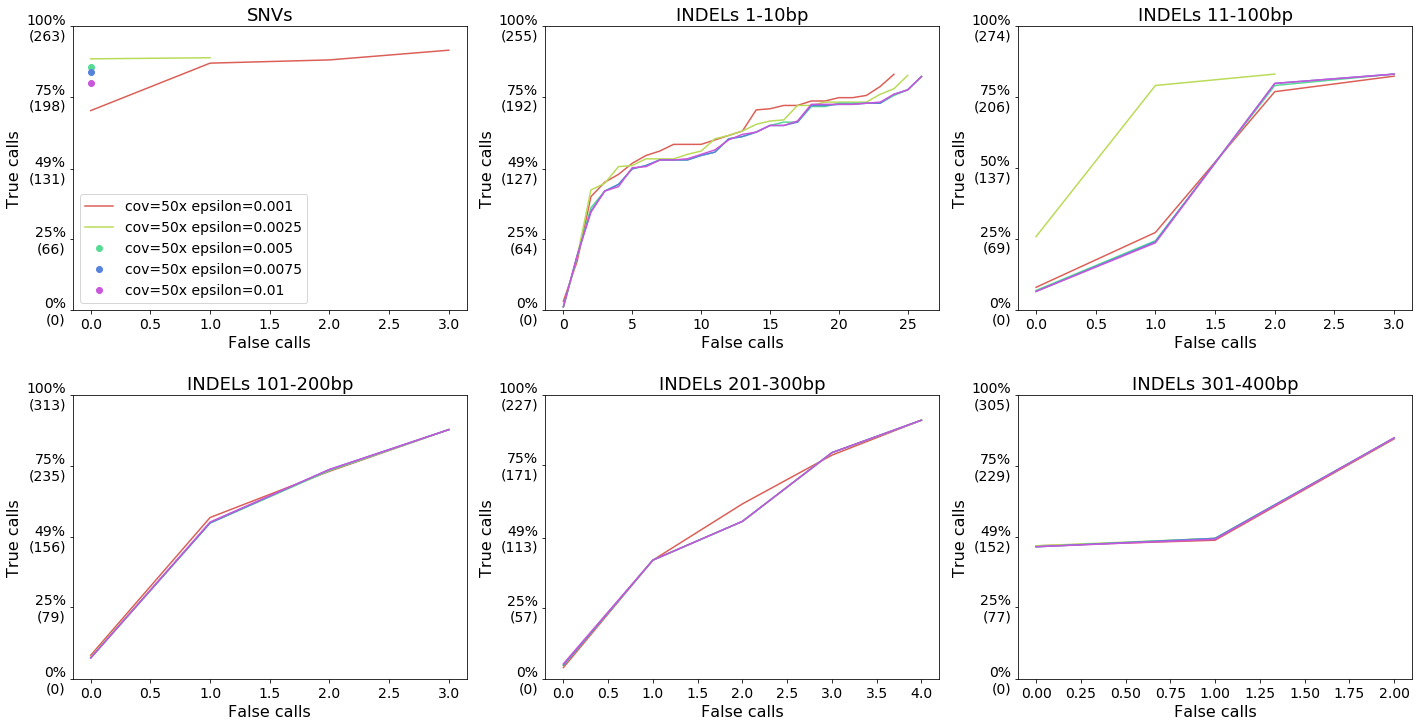

In [7]:
delta = 10
colors = seaborn.color_palette("hls", 5)

for cov in ['10', '20', '30', '50']:
    categories = [
        ('SNV', None, None, 'SNVs'),
        ('INDEL', 1, 10, 'INDELs 1-10bp'),
        ('INDEL', 11, 100, 'INDELs 11-100bp'),
        ('INDEL', 101, 200, 'INDELs 101-200bp'),
        ('INDEL', 201, 300, 'INDELs 201-300bp'),
        ('INDEL', 301, 400, 'INDELs 301-400bp'),
    ]
    fig, ((ax11, ax12, ax13), (ax21, ax22, ax23)) = plt.subplots(2, 3)
    axes = (ax11, ax12, ax13, ax21, ax22, ax23)
    seaborn.set_context({'figure.figsize': (24, 12)})
    
    for i, (category, axis) in enumerate(zip(categories, axes)):
        vartype, minlength, maxlength, label = category
        with kevlar.open('SimulatedVariants_chr17_hg38_markII.bed.gz', 'r') as instream:
            variants = subset_variants_bed(instream, vartype, minlength, maxlength)
            index = populate_index_from_bed(variants)
        
            for n, epsilon in enumerate(['0.001', '0.0025', '0.005', '0.0075', '0.01']):
                pattern = 'calls.{cov}x.k31.min*.eps{eps}.vcf.gz'.format(
                    cov=cov, eps=epsilon,
                )
                infilename = glob.glob(pattern)[0]
                kevlar_truecalls = roc(
                    load_kevlar_vcf(
                        infilename, index, delta=delta,
                        vartype=vartype, minlength=minlength, maxlength=maxlength
                    ),
                    index, delta=delta, fmt='vcf'
                )
                linelabel = 'cov={}x epsilon={}'.format(cov, epsilon)
                doplot(axis, kevlar_truecalls, colors[n], linelabel, '-', 'o')
            
            nvariants = len(index.trees['chr17'])
            ticknums = [0, math.ceil(nvariants * 0.25), int(nvariants * 0.5), math.ceil(nvariants * 0.75), nvariants]
            ticklabels = ['{:d}%\n({:d})'.format(int(tn / nvariants * 100), tn) for tn in ticknums]
            
            _ = axis.set_xlabel('False calls', fontsize=16)
            _ = axis.set_yticks(ticknums)
            _ = axis.set_yticklabels(ticklabels)
            _ = axis.set_ylabel('True calls', fontsize=16)
            _ = axis.set_ylim((0, nvariants))
            _ = axis.set_title(label, fontsize=18)
            if i == 0:
                _ = axis.legend(fontsize=14)
    
    _ = plt.subplots_adjust(hspace=0.3)
    _ = plt.savefig('sim-'+ cov +'x-paramwalk.png', dpi=300)
    _ = plt.show()